# 🧠 Bitcoin Price Prediction using Machine Learning

This notebook covers the complete pipeline for training a machine learning model to predict Bitcoin prices. The steps include:

- 📥 Loading historical BTC price data
- 🧹 Data preprocessing and feature engineering
- 🔍 Exploratory Data Analysis (EDA)
- 🏋️ Model training and evaluation
- 📈 Generating predictions for +1h and +24h ahead
- 💾 Saving predictions to Delta Lake for downstream use


In [0]:
%pip install xgboost
%pip install xgboost scikit-learn

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.dbutils import DBUtils
dbutils = DBUtils(spark)
dbutils.library.restartPython()

In [0]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.linalg import Vectors
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import VectorUDT
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, DoubleType
import numpy as np
from pyspark.sql.window import Window
from pyspark.sql.functions import collect_list, size, expr

In [0]:
# Get data from delta table
df = spark.read.table("bitcoin_prices.btc_data")
df.show()

+--------------------+-----------------+--------------------+--------------------+----------+
|           timestamp|            price|          market_cap|              volume|  hour_key|
+--------------------+-----------------+--------------------+--------------------+----------+
|2025-03-09 13:03:...|85036.72284003632|1.685309255973485E12|1.573842635257281...|2025030913|
|2025-03-09 14:09:...|84685.97978656797|1.679620171123259E12|1.641238880112382...|2025030914|
|2025-03-09 15:09:...| 83332.0655384259|1.659837325954614E12|1.714034444994676...|2025030915|
|2025-03-09 16:09:...| 83574.5108562199|1.661200644452682...|1.868091240853486...|2025030916|
|2025-03-09 17:02:...|83052.85746851926|1.647367452604472...|1.670361887857476...|2025030917|
|2025-03-09 18:04:...|82556.83567815712|1.634063957931177...|2.085556852642339...|2025030918|
|2025-03-09 19:09:...|82584.92274538855|1.633755471579755...|2.268729634116959...|2025030919|
|2025-03-09 20:07:...|82470.08205523597|1.637958272140605...

In [0]:
# Calculate Moving average convergence/divergence (MACD)

# EMA calculation helper
def ema(values, span):
    alpha = 2 / (span + 1)
    ema_values = []
    ema_prev = values[0]
    ema_values.append(ema_prev)
    
    for price in values[1:]:
        ema_now = alpha * price + (1 - alpha) * ema_prev
        ema_values.append(ema_now)
        ema_prev = ema_now
        
    return ema_values

# UDFs
from pyspark.sql.functions import udf

ema12_udf = udf(lambda x: ema(x, 12), ArrayType(DoubleType()))
ema26_udf = udf(lambda x: ema(x, 26), ArrayType(DoubleType()))

# Collect Price History
w_price = Window.orderBy("timestamp").rowsBetween(-100, 0)
df = df.withColumn("price_history", collect_list("price").over(w_price))

# Apply EMA UDFs
df = df.withColumn("ema12_series", ema12_udf("price_history"))
df = df.withColumn("ema26_series", ema26_udf("price_history"))

df = df.withColumn("ema12", expr("ema12_series[size(ema12_series)-1]"))
df = df.withColumn("ema26", expr("ema26_series[size(ema26_series)-1]"))

# Calculate MACD
df = df.withColumn("macd", df["ema12"] - df["ema26"])

# Clean up temporary columns
df = df.drop("price_history", "ema12_series", "ema26_series")

/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


In [0]:

# Step 1: Extract Time Features
df = df.withColumn('hour', F.hour(df['timestamp']))
df = df.withColumn('day', F.dayofmonth(df['timestamp']))
df = df.withColumn('day_of_week', F.dayofweek(df['timestamp']))  # 1 = Sunday, 7 = Saturday

# Step 2: Calculate Price Returns
df = df.withColumn('price_return_1h', (df['price'] - F.lag(df['price'], 1).over(Window.orderBy('timestamp'))) / F.lag(df['price'], 1).over(Window.orderBy('timestamp')))
df = df.withColumn('price_return_24h', (df['price'] - F.lag(df['price'], 24).over(Window.orderBy('timestamp'))) / F.lag(df['price'], 24).over(Window.orderBy('timestamp')))

# Step 3: Calculate Moving Averages
df = df.withColumn('ma_6h', F.avg(df['price']).over(Window.orderBy('timestamp').rowsBetween(-5, 0)))  # 6 hours moving average
df = df.withColumn('ma_24h', F.avg(df['price']).over(Window.orderBy('timestamp').rowsBetween(-23, 0)))  # 24 hours moving average
df = df.withColumn('ma_72h', F.avg(df['price']).over(Window.orderBy('timestamp').rowsBetween(-71, 0)))  # 72 hours moving average

# Step 4: Lag Features
df = df.withColumn('price_lag_1h', F.lag(df['price'], 1).over(Window.orderBy('timestamp')))
df = df.withColumn('price_lag_24h', F.lag(df['price'], 24).over(Window.orderBy('timestamp')))

# Step 5: Calculate Volatility
df = df.withColumn('volatility_6h', F.stddev(df['price']).over(Window.orderBy('timestamp').rowsBetween(-5, 0)))
df = df.withColumn('volatility_24h', F.stddev(df['price']).over(Window.orderBy('timestamp').rowsBetween(-23, 0)))

# Step 6: Momentum
df = df.withColumn("momentum_1h", df["price"] - df["price_lag_1h"])
df = df.withColumn("momentum_6h", df["price"] - df["ma_6h"])
df = df.withColumn("momentum_24h", df["price"] - df["ma_24h"])
df = df.withColumn("momentum_72h", df["price"] - df["ma_72h"])

# Step 7: Lag and Moving Average
df = df.withColumn("volume_lag_1h", F.lag("volume", 1).over(Window.orderBy("timestamp")))
df = df.withColumn("volume_lag_24h", F.lag("volume", 24).over(Window.orderBy("timestamp")))
df = df.withColumn("volume_ma_6h", F.avg("volume").over(Window.orderBy("timestamp").rowsBetween(-5, 0)))
df = df.withColumn("volume_ma_24h", F.avg("volume").over(Window.orderBy("timestamp").rowsBetween(-23, 0)))

# Step 8: Volume return
df = df.withColumn("volume_return_1h", 
    (df["volume"] - df["volume_lag_1h"]) / df["volume_lag_1h"]
)

# Step 9: Calculate RSI
# Price change
df = df.withColumn("delta", df["price"] - F.lag("price", 1).over(Window.orderBy("timestamp")))
# Gains and losses
df = df.withColumn("gain", F.when(df["delta"] > 0, df["delta"]).otherwise(0))
df = df.withColumn("loss", F.when(df["delta"] < 0, -df["delta"]).otherwise(0))
# Average gain/loss over 14 periods
avg_window = Window.orderBy("timestamp").rowsBetween(-13, 0)
df = df.withColumn("avg_gain", F.avg("gain").over(avg_window))
df = df.withColumn("avg_loss", F.avg("loss").over(avg_window))
# RS and RSI
df = df.withColumn("rs", df["avg_gain"] / (df["avg_loss"] + F.lit(1e-9)))  # Avoid div/0
df = df.withColumn("rsi_14", 100 - (100 / (1 + df["rs"])))

# Step 10: Hourly rolling trend 
# Price increase compared to previous hour
df = df.withColumn("price_increase", F.when(df["delta"] > 0, 1).otherwise(0))
# Sum over rolling 6 hours
trend_window = Window.orderBy("timestamp").rowsBetween(-5, 0)
df = df.withColumn("trend_up_count_6h", F.sum("price_increase").over(trend_window))

# Step 11: Clean up
df = df.drop("delta", "gain", "loss", "avg_gain", "avg_loss", "rs")
df = df.dropna()

# Step 12: Drop NaNs
df = df.dropna()

# Show the resulting DataFrame
df.show()


/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


+--------------------+-----------------+--------------------+--------------------+----------+-----------------+-----------------+-------------------+----+---+-----------+--------------------+--------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------+-----------------+--------------------+--------------------+
|           timestamp|            price|          market_cap|              volume|  hour_key|            ema12|            ema26|               macd|hour|day|day_of_week|     price_return_1h|    price_return_24h|            ma_6h|           ma_24h|           ma_72h|     price_lag_1h|    price_lag_24h|     volatility_6h|    volatility_24h|        momentum_1h|        momentum_6h|

In [0]:
# Define a UDF to create a dense vector from the feature columns
def create_feature_vector(*features):
    return Vectors.dense(features)

# Register the UDF
feature_vector_udf = udf(create_feature_vector, VectorUDT())

# Apply the UDF to create the 'features' column with all engineered features
df = df.withColumn(
    'features',
    feature_vector_udf(
        col('macd'),
        col('price'),
        col('hour'),
        col('day'),
        col('day_of_week'),
        col('price_return_1h'),
        col('price_return_24h'),
        col('ma_6h'),
        col('ma_24h'),
        col('ma_72h'),
        col('price_lag_1h'),
        col('price_lag_24h'),
        col('volatility_6h'),
        col('volatility_24h'),
        col('momentum_1h'),
        col('momentum_6h'),
        col('momentum_24h'),
        col('momentum_72h'),
        col('volume_lag_1h'),
        col('volume_lag_24h'),
        col('volume_ma_6h'),
        col('volume_ma_24h'),
        col('volume_return_1h'),
        col('rsi_14'),
        col('trend_up_count_6h')
    )
)


/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Train model

/databricks/python/lib/python3.11/site-packages/pyspark/sql/connect/expressions.py:1017: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-83ad1456-9e21-436d-85a6-0046b8b1af05/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:36:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-83ad1456-9e21-436d-85a6-0046b8b1af05/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:36:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-83ad1456-9e21-436d-85a6-0046b8b1af05/lib/python3.11/site-packages/xgboost/training.py:183: UserWa

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Accuracy (default threshold 0.5): 0.60
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.62      0.58       187
           1       0.65      0.58      0.61       224

    accuracy                           0.60       411
   macro avg       0.60      0.60      0.60       411
weighted avg       0.60      0.60      0.60       411


Summary of confidence-based performance:
 Total Predictions  Confident Predictions (≥70%)  Confident & Correct  Confident Accuracy
               411                           101                   67            0.663366

Best Threshold for F1: 0.11
Accuracy (best threshold): 0.55
Classification Report (best threshold):
               precision    recall  f1-score   support

           0       1.00      0.01      0.02       187
           1       0.55      1.00      0.71       224

  

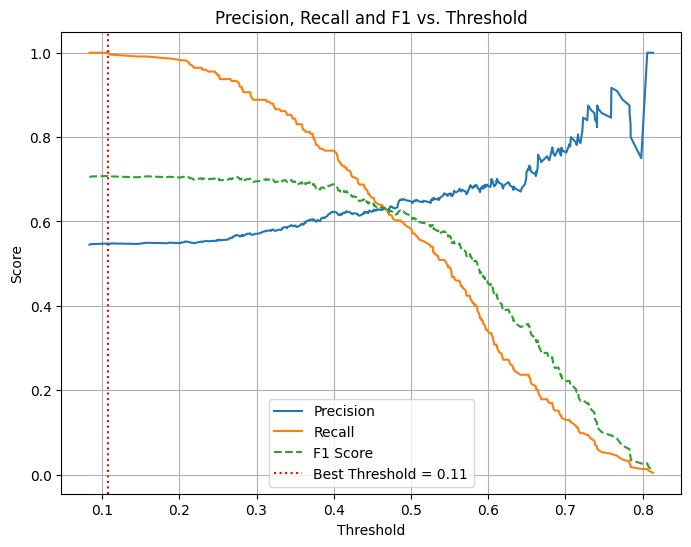


Top 10 Confident Predictions:
 actual  predicted  prob_up  prob_down  confidence  is_confident  correct  is_confident_correct
      0          0 0.083611   0.916389    0.916389          True     True                  True
      0          0 0.086221   0.913779    0.913779          True     True                  True
      1          0 0.107700   0.892300    0.892300          True    False                 False
      0          0 0.110005   0.889995    0.889995          True     True                  True
      1          0 0.110726   0.889274    0.889274          True    False                 False
      0          0 0.146190   0.853810    0.853810          True     True                  True
      0          0 0.151745   0.848255    0.848255          True     True                  True
      1          0 0.157838   0.842162    0.842162          True    False                 False
      0          0 0.184434   0.815566    0.815566          True     True                  True
      1  

In [0]:
# Step 1: Import necessary libraries
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Define feature columns and remove unwanted columns
feature_columns = [col for col in df.columns if col not in ['price', 'timestamp', 'features']]

# Step 3: Convert Spark DataFrame to Pandas
df_pandas = df.select(feature_columns + ['price']).toPandas()

# Step 4: Create target variable: 1 if price goes up in next row, 0 otherwise
df_pandas['price_next'] = df_pandas['price'].shift(-1)
df_pandas['target'] = (df_pandas['price_next'] > df_pandas['price']).astype(int)
df_pandas.dropna(inplace=True)

# Step 5: Split features and target
X = df_pandas[feature_columns]
y = df_pandas['target']

# Step 6: Train-test split (no shuffle due to time dependency)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 7: Hyperparameter tuning with GridSearchCV
param_grid = {
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy'
)

# Step 8: Train the model
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Step 9: Predict with best model
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# Step 10: Evaluate performance
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy (default threshold 0.5): {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 11: Analyze prediction confidence
results_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred,
    'prob_up': y_proba[:, 1],
    'prob_down': y_proba[:, 0]
})

results_df['confidence'] = results_df[['prob_up', 'prob_down']].max(axis=1)
results_df['is_confident'] = results_df['confidence'] >= 0.7
results_df['correct'] = results_df['actual'] == results_df['predicted']
results_df['is_confident_correct'] = results_df['is_confident'] & results_df['correct']

# Step 12: Summary statistics
total_predictions = len(results_df)
confident_predictions = results_df['is_confident'].sum()
confident_correct = results_df['is_confident_correct'].sum()

summary_df = pd.DataFrame({
    'Total Predictions': [total_predictions],
    'Confident Predictions (≥70%)': [confident_predictions],
    'Confident & Correct': [confident_correct],
    'Confident Accuracy': [confident_correct / confident_predictions if confident_predictions else 0]
})

print("\nSummary of confidence-based performance:")
print(summary_df.to_string(index=False))

# Step 13: Optimize threshold using F1 Score
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:, 1])
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

# Apply best threshold
y_pred_best_thresh = (y_proba[:, 1] >= best_threshold).astype(int)

print(f"\nBest Threshold for F1: {best_threshold:.2f}")
print(f"Accuracy (best threshold): {accuracy_score(y_test, y_pred_best_thresh):.2f}")
print("Classification Report (best threshold):\n", classification_report(y_test, y_pred_best_thresh))

# Step 14: Plot threshold performance
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score', linestyle='--')
plt.axvline(best_threshold, color='red', linestyle=':', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall and F1 vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Step 15: Print top confident predictions (optional)
print("\nTop 10 Confident Predictions:")
print(results_df.sort_values('confidence', ascending=False).head(10).to_string(index=False))

# Step 16: Print feature names used in model
print("\nModel trained on features:")
print(feature_columns)


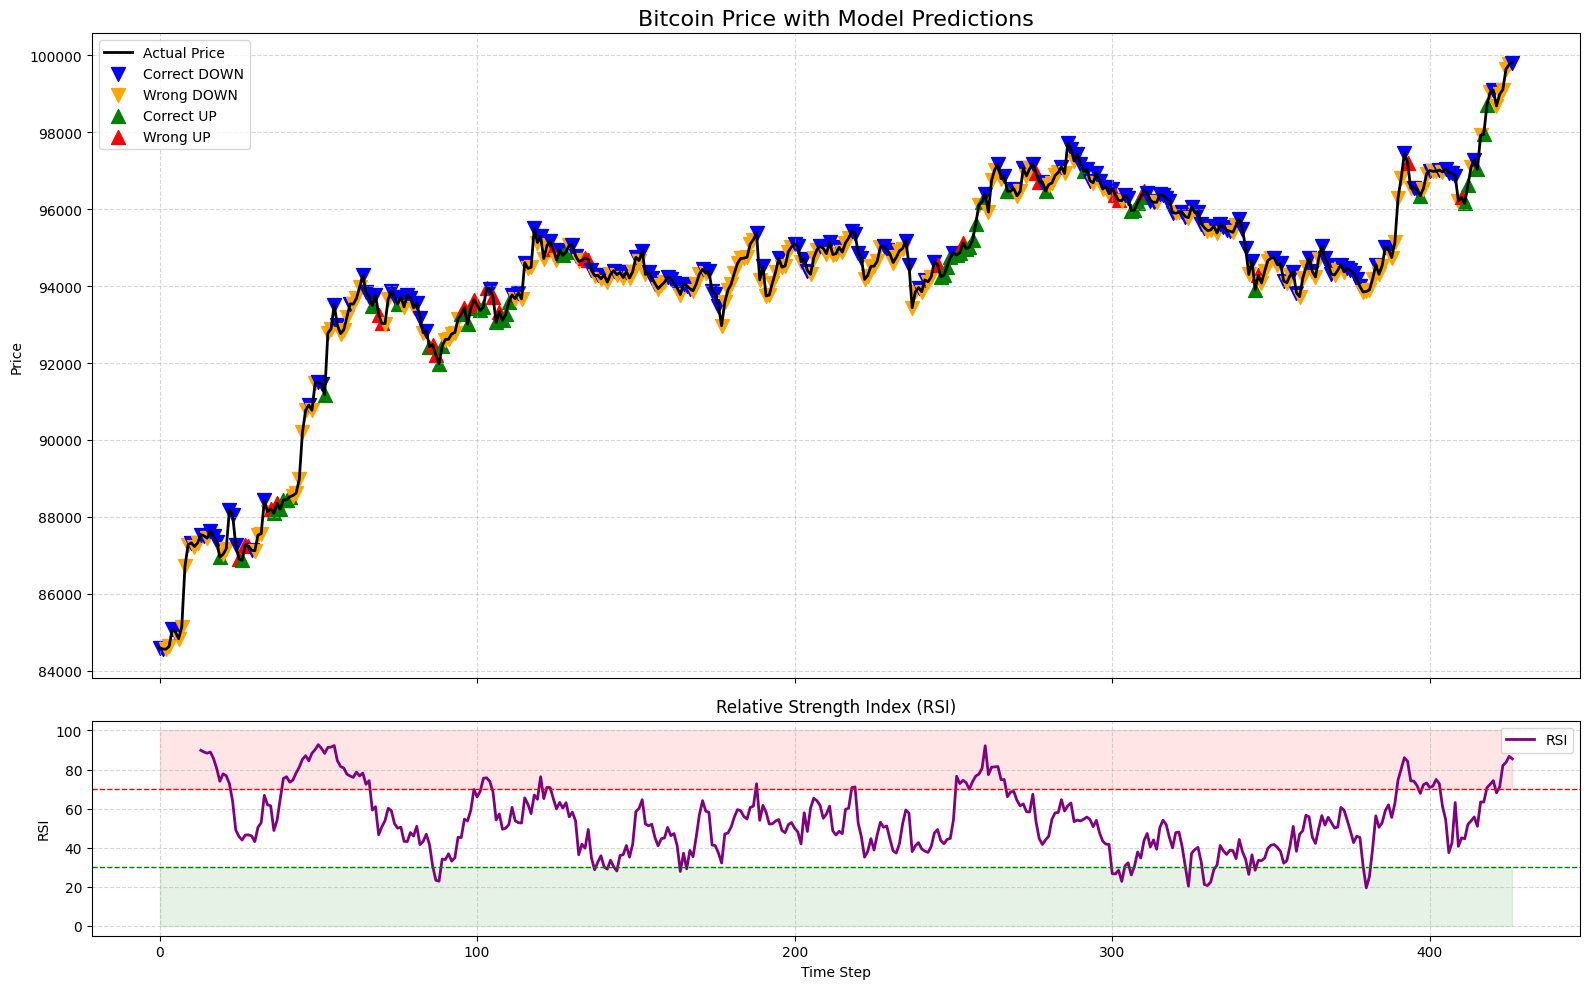

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === 1. Prepare the Data ===
df_plot = X_test.copy()
df_plot = df_plot.reset_index(drop=True)  # Ensure alignment with predicted results
df_plot['price'] = df_pandas.loc[X_test.index, 'price'].reset_index(drop=True)
df_plot['price_next'] = df_pandas.loc[X_test.index, 'price_next'].reset_index(drop=True)
df_plot['actual_direction'] = y_test.reset_index(drop=True)
df_plot['predicted_direction'] = results_df['predicted'].reset_index(drop=True)
df_plot['correct'] = df_plot['actual_direction'] == df_plot['predicted_direction']

# === 2. Compute RSI ===
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_plot['RSI'] = compute_rsi(df_plot['price'])

# === 3. Create the Plot with Subplots ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# --- Top Plot: Price with Predictions ---
ax1.plot(df_plot.index, df_plot['price'], label='Actual Price', color='black', linewidth=2)

for idx, row in df_plot.iterrows():
    x = idx
    y = row['price']
    if row['predicted_direction'] == 1:  # Prediction 'up'
        if row['correct']:
            ax1.scatter(x, y, color='green', marker='^', s=100, label='Correct UP' if 'Correct UP' not in ax1.get_legend_handles_labels()[1] else "")
        else:
            ax1.scatter(x, y, color='red', marker='^', s=100, label='Wrong UP' if 'Wrong UP' not in ax1.get_legend_handles_labels()[1] else "")
    else:  # Prediction 'down'
        if row['correct']:
            ax1.scatter(x, y, color='blue', marker='v', s=100, label='Correct DOWN' if 'Correct DOWN' not in ax1.get_legend_handles_labels()[1] else "")
        else:
            ax1.scatter(x, y, color='orange', marker='v', s=100, label='Wrong DOWN' if 'Wrong DOWN' not in ax1.get_legend_handles_labels()[1] else "")

ax1.set_title('Bitcoin Price with Model Predictions', fontsize=16)
ax1.set_ylabel('Price')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend()

# --- Bottom Plot: RSI ---
ax2.plot(df_plot.index, df_plot['RSI'], label='RSI', color='purple', linewidth=2)
ax2.axhline(70, color='red', linestyle='--', linewidth=1)
ax2.axhline(30, color='green', linestyle='--', linewidth=1)
ax2.fill_between(df_plot.index, 70, 100, color='red', alpha=0.1)
ax2.fill_between(df_plot.index, 0, 30, color='green', alpha=0.1)

ax2.set_title('Relative Strength Index (RSI)')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('RSI')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend()

# Layout and display
plt.tight_layout()
plt.show()


In [0]:
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))


Train target distribution:
 0    0.502342
1    0.497658
Name: target, dtype: float64
Test target distribution:
 1    0.548009
0    0.451991
Name: target, dtype: float64


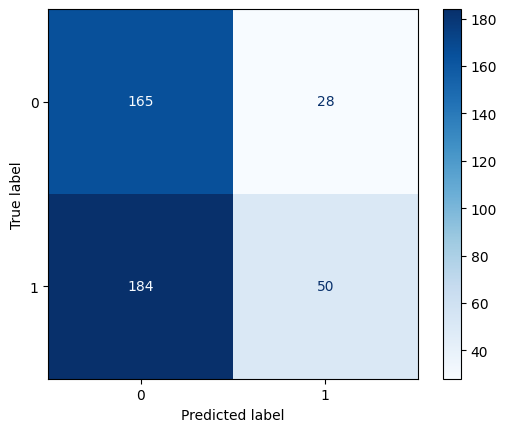

In [0]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")


In [0]:
from sklearn.model_selection import train_test_split

# Prepare features, target, and returns
X = df_pandas[feature_columns]
y = df_pandas['price_increase']  # Binary classification target
returns = df_pandas['price_return_1h']  # Actual % return in the next hour

# Train-test split including returns
X_train, X_test, y_train, y_test, returns_train, returns_test = train_test_split(
    X, y, returns, test_size=0.2, shuffle=False  # Use shuffle=True if not time-series
)

# Make predictions
y_pred = best_model.predict(X_test)

# --- Predicted UP Trades ---
predicted_up_returns = returns_test[y_pred == 1]
avg_return_up = predicted_up_returns.mean()
win_rate_up = (predicted_up_returns > 0).mean()
total_signals_up = len(predicted_up_returns)

print(f"\nTrading Signal Stats (Predicted UP):")
print(f"Total Signals: {total_signals_up}")
print(f"Average Return per Trade: {avg_return_up:.4f}")
print(f"Win Rate: {win_rate_up:.2%}")

# --- Predicted DOWN Trades ---
predicted_down_returns = returns_test[y_pred == 0]
avg_return_down = predicted_down_returns.mean()
win_rate_down = (predicted_down_returns < 0).mean()
total_signals_down = len(predicted_down_returns)

print(f"\nTrading Signal Stats (Predicted DOWN):")
print(f"Total Signals: {total_signals_down}")
print(f"Average Return per Trade: {avg_return_down:.4f}")
print(f"Win Rate (correctly predicted down): {win_rate_down:.2%}")



Trading Signal Stats (Predicted UP):
Total Signals: 78
Average Return per Trade: -0.0003
Win Rate: 48.72%

Trading Signal Stats (Predicted DOWN):
Total Signals: 349
Average Return per Trade: 0.0005
Win Rate (correctly predicted down): 43.55%


Hyper parameter tuning

In [0]:
from datetime import datetime
import pytz
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, BooleanType, StringType

# Add timestamp and hour_key
swedish_tz = pytz.timezone('Europe/Stockholm')
now_se = datetime.now(tz=swedish_tz)
results_df['timestamp'] = now_se.strftime('%Y-%m-%d %H:%M:%S')
results_df['hour_key'] = int(now_se.replace(minute=0, second=0, microsecond=0).strftime('%Y%m%d%H'))

# Define schema
schema = StructType([
    StructField("actual", IntegerType(), True),
    StructField("predicted", IntegerType(), True),
    StructField("prob_up", DoubleType(), True),
    StructField("prob_down", DoubleType(), True),
    StructField("confidence", DoubleType(), True),
    StructField("is_confident", BooleanType(), True),
    StructField("correct", BooleanType(), True),
    StructField("is_confident_correct", BooleanType(), True),
    StructField("timestamp", StringType(), True),
    StructField("hour_key", IntegerType(), True)
])

# Convert to Spark DataFrame
spark_results_df = spark.createDataFrame(results_df, schema=schema)

# Save to Delta table
spark_results_df.write.format("delta").mode("append").saveAsTable("bitcoin_prices.btc_direction_predictions")
